In [5]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

In [6]:
## JACOB KIRSCH

In [7]:
path21 = "2021sample.csv"
path24 = "savant_data (1).csv"
def load_data(path):
    df = pd.read_csv(path)
    return df

In [8]:
def clean_data(df):
    df.replace(['None', 'NaN'], pd.NA, inplace=True)
    df[['on_3b','on_2b','on_1b']] = df[['on_3b','on_2b','on_1b']].notna().astype(int)
    df = df.dropna(subset= ['zone'])
    df['inzone'] = np.where((df['zone'] >=1) & (df['zone'] <= 9),1,0)
    df = df.drop(df.columns[0],axis = 1)
    df['description'].unique().tolist()
    remove_descrips = ['pitchout','foul_bunt','bunt_foul_tip','hit_by_pitch','missed_bunt']
    df = df[~df['description'].isin(remove_descrips)]
    df['description'].unique().tolist()
    swing_descs = ['swinging_strike','hit_into_play','foul','foul_tip','swinging_strike_blocked']
    df['swing'] = np.where((df['description'].isin(swing_descs)),1,0)
    df['count'] = df.apply(lambda row: f"{row['balls']}-{row['strikes']}",axis = 1)
    df['runners'] = df[['on_1b','on_2b','on_3b']].sum(axis=1)
    return df

In [9]:
def create_strike_subset(df):
    two_strike = df[df['strikes'] == 2]
    return two_strike
def create_outzone_subset(df):
    out_of_zone = df[df['inzone'] == 0]
    return out_of_zone
def swing_reg(df):
    """
    Runs a logistic regression on swing rate predicted on runners, strikes, outs, and balls.
    Then prints the summary 
    """
    result = df['swing']
    predictors = df[['runners','strikes','outs_when_up','balls']]
    model = sm.Logit(result,predictors).fit(cov_type = 'HC1')
    print(model.summary())
def protect_plate_reg(df):
    """
    Runs a logistic regression on swing rate predicted on runners, strikes, outs, and balls.
    Then prints the summary 
    Only looks at pitches that are out of the zone
    """
    balls_sub = create_outzone_subset(df)
    result = balls_sub['swing']
    predictors = balls_sub[['runners','strikes','outs_when_up','balls']]
    model = sm.Logit(result,predictors).fit(cov_type = 'HC1')
    print(model.summary())
def create_subplots(df):
    grouped_outs = df.groupby('outs_when_up')['swing'].mean().reset_index()
    grouped_strikes = df.groupby('strikes')['swing'].mean().reset_index()
    grouped_runners = df.groupby('runners')['swing'].mean().reset_index()
    grouped_balls = df.groupby('balls')['swing'].mean().reset_index()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(grouped_outs['outs_when_up'], grouped_outs['swing'], marker='o', linestyle='-')
    ax1.set_xlabel('Outs')
    ax1.set_ylabel('Average Swing Rate')
    ax1.set_title('Swing Rate by Outs')
    ax1.grid(True)
    
    ax2.plot(grouped_runners['runners'], grouped_runners['swing'], marker='o', linestyle='-')
    ax2.set_xlabel('Runners')
    ax2.set_ylabel('Swing Rate')
    ax2.set_title('Swing Rate by Runners')
    ax2.grid(True)
    
    ax3.plot(grouped_strikes['strikes'], grouped_strikes['swing'], marker='o', linestyle='-')
    ax3.set_xlabel('Strikes')
    ax3.set_ylabel('Swing Rate')
    ax3.set_title('Swing Rate by Strikes')
    ax3.grid(True)
    
    ax4.plot(grouped_balls['balls'], grouped_balls['swing'], marker='o', linestyle='-')
    ax4.set_xlabel('Balls')
    ax4.set_ylabel('Swing Rate')
    ax4.set_title('Swing Rate by Balls')
    ax4.grid(True)
    
    fig.subplots_adjust(hspace = 0.5,wspace = 0.5)
def create_count_plot(df,color = 'skyblue'):
    """
    Creates and displays a plot that shows the average swing rate for each different count
    """
    grouped_count = df.groupby('count')['swing'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(grouped_count['count'], grouped_count['swing'], color=color)
    
    
    plt.xlabel('Count')
    plt.ylabel('Swing Rate')
    plt.title('Swing Rate by Count')
    plt.grid(axis='y')
    
    
    plt.show()
def create_swing_length_plot(df):
    """
    Creates a plot comparing swing length and number of strikes
    """
    swings24 = df[df['swing'] == 1]
    groupby_strike = swings24.groupby('strikes')['swing_length'].mean().reset_index()
    plt.plot(groupby_strike['strikes'],groupby_strike['swing_length'],marker = 'o')
    plt.xlabel('Number of Strikes')
    plt.ylabel('Swing Length')
    plt.title('Swing Length by Strikes')
    plt.xticks(groupby_strike['strikes'])
    plt.show()

def swing_length_reg(df):
    swings24 = df[df['swing'] == 1]
    swings24 = swings24.dropna(subset= ['swing_length'])
    data24 = load_data(path24)
    y = swings24['swing_length']
    x = swings24['strikes']
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit(cov_type = 'HC1')
    print(model.summary())

In [10]:
data24 = clean_data(load_data(path24))
data21 = clean_data(load_data(path21))

/tmp/ipykernel_815/1695761337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inzone'] = np.where((df['zone'] >=1) & (df['zone'] <= 9),1,0)


In [11]:
swing_reg(data21)
protect_plate_reg(data21)

Optimization terminated successfully.
         Current function value: 0.677682
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  swing   No. Observations:                49700
Model:                          Logit   Df Residuals:                    49696
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 May 2024   Pseudo R-squ.:                 0.02064
Time:                        18:54:19   Log-Likelihood:                -33681.
converged:                       True   LL-Null:                       -34391.
Covariance Type:                  HC1   LLR p-value:                1.682e-307
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
runners         -0.0433      0.011     -3.796      0.000      -0.066      -0.021
strikes          0.3024

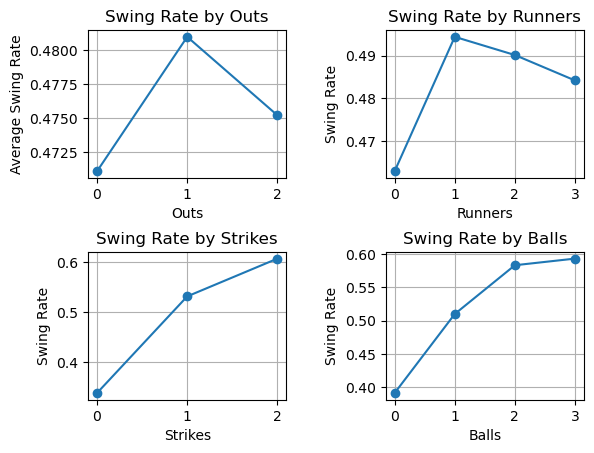

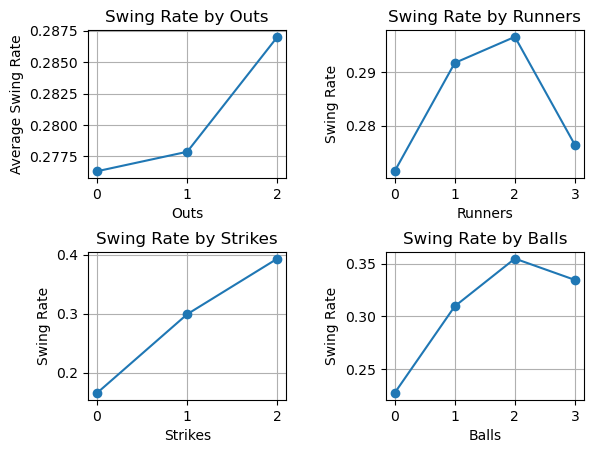

In [12]:
create_subplots(data21)
create_subplots(create_outzone_subset(data21))

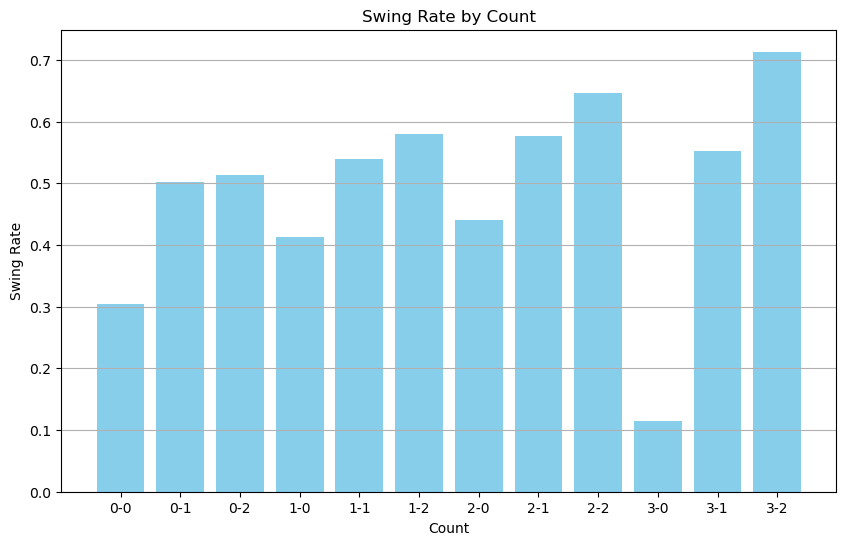

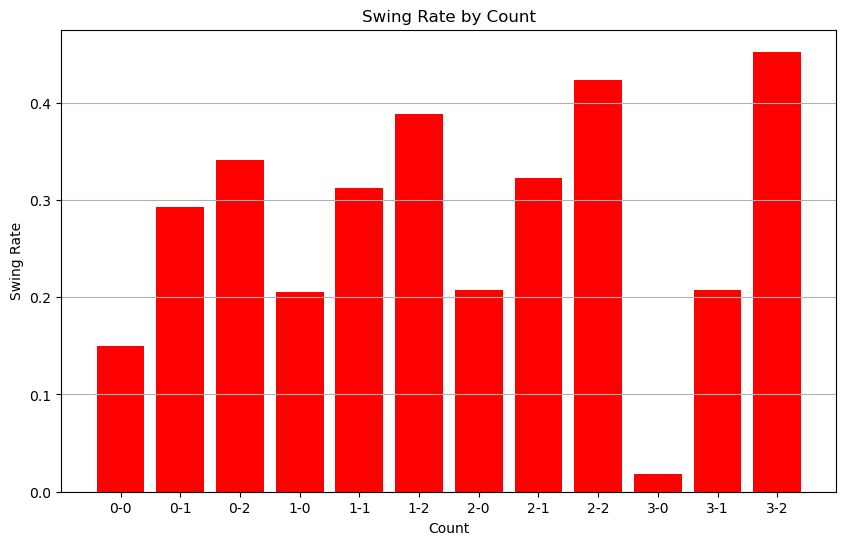

In [13]:
create_count_plot(data21)
create_count_plot(create_outzone_subset(data21),'red')

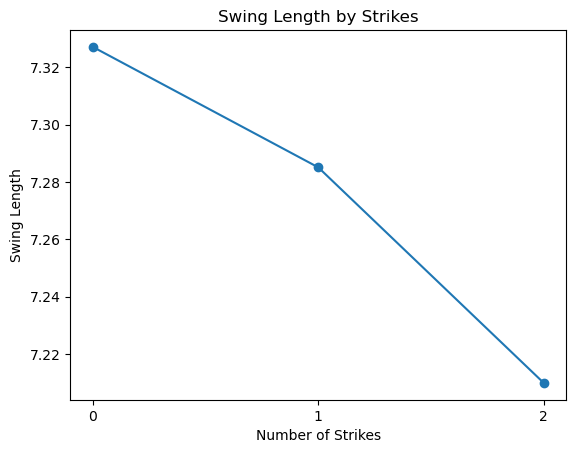

                            OLS Regression Results                            
Dep. Variable:           swing_length   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     34.29
Date:                Tue, 28 May 2024   Prob (F-statistic):           4.88e-09
Time:                        18:54:30   Log-Likelihood:                -15053.
No. Observations:               11589   AIC:                         3.011e+04
Df Residuals:                   11587   BIC:                         3.012e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3337      0.014    540.185      0.0

In [14]:
create_swing_length_plot(data24)
swing_length_reg(data24)

In [15]:
## JAKE ZESIGER

In [19]:
# Runs regression between pitch velocity, breaking pitch usage, and Tommy Johns
# Read in the TJs data set
tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Player", "TJ Surgery Date"])

# clean up the tommy john data by dropping Nulls and changing the 
tommy_johns = tommy_johns.dropna(how = 'all')
tommy_johns['Player'] = tommy_johns['Player'].apply(lambda x: ', '.join(x.split()[::-1]))
tommy_johns['TJ Surgery Date'] = pd.to_datetime(tommy_johns['TJ Surgery Date'])


# Reads in multiple data sets for pitch velocity and pitch spin rate then concats all the data together
pitch_velocity = pd.read_csv('pitch_velocity_1.csv', usecols = ["player_name", "velocity", "api_game_date_month_text", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('pitch_velocity_' + str(i) + '.csv', usecols = ["player_name", "velocity", "api_game_date_month_text", "year"])
    pitch_velocity = pd.concat([pitch_velocity, temp_pd], ignore_index = True)

spin_rate = pd.read_csv('spin_rate_1.csv', usecols = ["player_name", "pitch_percent", "api_game_date_month_text", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('spin_rate_' + str(i) + '.csv', usecols = ["player_name", "pitch_percent", "api_game_date_month_text", "year"])
    spin_rate = pd.concat([spin_rate, temp_pd], ignore_index = True)

pitcher_data = pd.merge(pitch_velocity, spin_rate, how = 'left', left_on = ['player_name', 'api_game_date_month_text', 'year'],
                                                                right_on = ['player_name', 'api_game_date_month_text', 'year'])
pitcher_data = pitcher_data.dropna(subset = ['pitch_percent'])


# Creates a mapping for turning a str month into a int month
month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar/Apr': '03',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep/Oct': '09',
    'Nov': '11',
    'Dec': '12'
}

# Uses map above to turn a dataframe from str months into a int months
def replace_month(date_str):
    for month_str, month_num in month_map.items():
        date_str = date_str.replace(month_str, month_num)
    return date_str

# Turns the months in the aggregated pitcher data into numbers not strings
pitcher_data['api_game_date_month_text'] = pitcher_data['api_game_date_month_text'].apply(replace_month)


# Merges the two data sets together and turns the date of when someone got a TJ into a 1
result = pd.merge(pitcher_data, tommy_johns, how = 'left', left_on = ['player_name'], right_on = ['Player'])
result['TJ'] = result['TJ Surgery Date'].notna().astype(int)

# Gets rid of the data after someone got a TJ (Only by year though)
temp = result[result['TJ Surgery Date'].dt.year >= result['year']]

# Adds together the data where after the TJ it doesn't matter and if someone never got a TJ
result2 = result[result['TJ'] == 0]
final_result = pd.concat([result2, temp], ignore_index = True)

# Aggregates all the data for a specific player taking the mean of the velocity, TJ (Either 0 or 1 so mean shouldnt change), and spin rate
final_result = result.groupby(['player_name'], as_index = False)[['TJ', 'velocity', 'pitch_percent']].mean()

# Runs a logistic Regression on the data with TJ being the y variable
model = sm.Logit(final_result['TJ'], final_result[['velocity', 'pitch_percent']]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.604516
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     TJ   No. Observations:                 2893
Model:                          Logit   Df Residuals:                     2891
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 May 2024   Pseudo R-squ.:               -0.002369
Time:                        19:05:19   Log-Likelihood:                -1748.9
converged:                       True   LL-Null:                       -1744.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
velocity         -0.0085      0.001     -7.934      0.000      -0.011      -0.006
pitch_percent    -0.0034      0.003     -1.064      0.287      -0.010       0.003
=================================================================================
"""

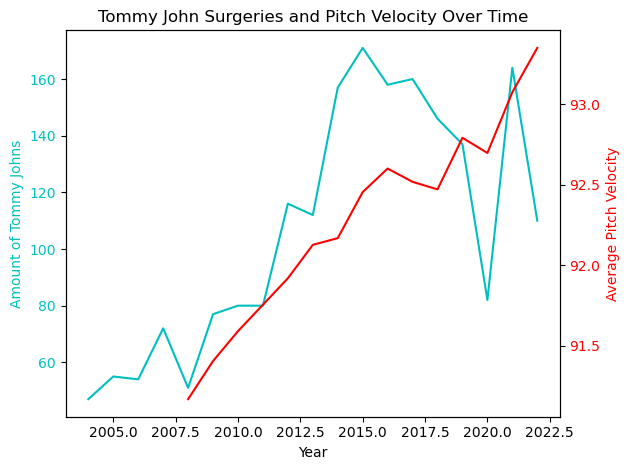

In [20]:
# Plots Tommy Johns vs pitch velocity
# Reads in the data for tommy johns
tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Year"])
tommy_johns = tommy_johns.dropna(how = 'all')
counts = tommy_johns['Year'].value_counts(sort = False).reset_index()
counts = counts[counts['Year'] > 2003]
counts = counts[counts['Year'] < 2023]

# Gets the data for pitch velocity
pitch_velocity = pd.read_csv('pitch_velocity_1.csv', usecols = ["player_name", "velocity", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('pitch_velocity_' + str(i) + '.csv', usecols = ["player_name", "velocity", "year"])
    pitch_velocity = pd.concat([pitch_velocity, temp_pd], ignore_index = True)

pitch_velocity = pitch_velocity[pitch_velocity['year'] < 2023]

# Takes the average of each year's velocity
pitch_velocity2 = pitch_velocity.groupby(['year'], as_index = False)[['velocity']].mean()

# All of this plots the two lines on the same graph with different y axis
fig, ax1 = plt.subplots()

ax1.plot(counts['Year'], counts['count'], color='c', label='Value1')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount of Tommy Johns', color='c')
ax1.tick_params(axis='y', labelcolor='c')

ax2 = ax1.twinx()
ax2.plot(pitch_velocity2['year'], pitch_velocity2['velocity'], color='r', label='Value2')
ax2.set_ylabel('Average Pitch Velocity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Tommy John Surgeries and Pitch Velocity Over Time')
fig.tight_layout()

plt.show()

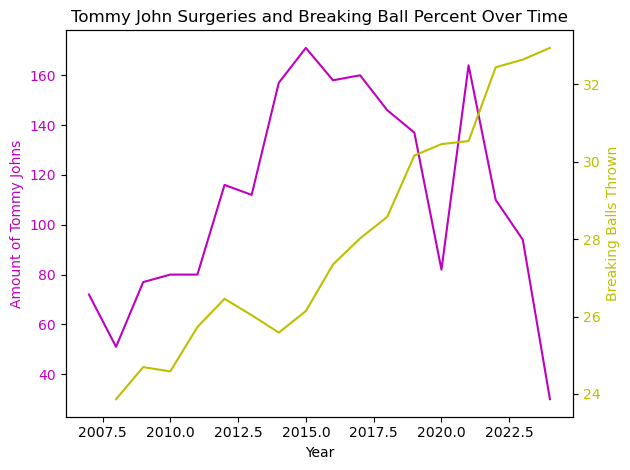

In [21]:
# Plots Tommy Johns vs brekaing pitches usage
# Reads in the data for tommy johns
tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Year"])
tommy_johns = tommy_johns.dropna(how = 'all')
counts = tommy_johns['Year'].value_counts(sort = False).reset_index()
counts = counts[counts['Year'] > 2006]

# Gets the data for breaking pitches
spin_rate = pd.read_csv('spin_rate_1.csv', usecols = ["player_name", "pitch_percent", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('spin_rate_' + str(i) + '.csv', usecols = ["player_name", "pitch_percent", "year"])
    spin_rate = pd.concat([spin_rate, temp_pd], ignore_index = True)

# Takes the average of each year's breaking pitches usage
spin_rate2 = spin_rate.groupby(['year'], as_index = False)[['pitch_percent']].mean()

# All of this plots the two lines on the same graph with different y axis
fig, ax1 = plt.subplots()

ax1.plot(counts['Year'], counts['count'], color='m', label='Value1')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount of Tommy Johns', color='m')
ax1.tick_params(axis='y', labelcolor='m')

ax2 = ax1.twinx()
ax2.plot(spin_rate2['year'], spin_rate2['pitch_percent'], color='y', label='Value2')
ax2.set_ylabel('Breaking Balls Thrown', color='y')
ax2.tick_params(axis='y', labelcolor='y')

plt.title('Tommy John Surgeries and Breaking Ball Percent Over Time')
fig.tight_layout()

plt.show()